In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# **Trial-by-trial Analysis of SCR-ROI response for shock**

In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)

cmap = plt.get_cmap('Set1')

In [3]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
SCR_betapath = join(eCON,'SCR_new/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/shock_IM/{subj}_bucket_REML_clean.1D')
roi_betapath = join(eCON,'dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_{roi}/noProx/shock_IM/{subj}_bucket_REML.1D')
yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [4]:
rois = 'rvAI rdAI lvAI ldAI rPI lPI rBNST lBNST ACC\
        Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L\
        rCa lCa rPa lPa rVS lVS vmPFC PCC1 PCC2 rPAG1 lPAG1'.split()

24

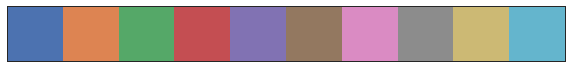

In [5]:
pal = sns.color_palette()
sns.palplot(pal)
len(rois)

In [6]:
if not exists('data/ROIs_SCR_trial_by_trial.csv'):    
    df = pd.DataFrame()
    for i, row in yoked.iterrows():
        for kind in ['control','uncontrol']:
            #print(row[kind])
            scr_beta = np.loadtxt(SCR_betapath.format(subj=row[kind],group=kind))[25::2]
            roi_beta = np.vstack([np.loadtxt(roi_betapath.format(subj=row[kind],roi=roi,group=kind))[25::2] for roi in rois]).T
            all_betas = np.concatenate((scr_beta[:,None],roi_beta),axis=1)

            tmp_df = pd.DataFrame(all_betas,columns=['SCR']+rois)
            tmp_df['SubjID'] = row[kind]
            tmp_df['Group'] = kind
            tmp_df['Pair'] = 'P{:02d}'.format(i)
            df = pd.concat([df,tmp_df],axis =0)
    df.to_csv('data/ROIs_SCR_trial_by_trial.csv',sep='\t',index=False,float_format='%.4f')
else:
    df = pd.read_csv('data/ROIs_SCR_trial_by_trial.csv',sep='\t')

In [7]:
df.head()

,SCR,rvAI,rdAI,lvAI,ldAI,rPI,lPI,rBNST,lBNST,ACC,...,rVS,lVS,vmPFC,PCC1,PCC2,rPAG1,lPAG1,SubjID,Group,Pair
0,8.6095,1.7816,2.1119,-1.0575,2.9644,3.1084,2.7786,6.3267,4.8373,2.6326,...,1.6020,1.2372,2.3129,-0.4296,3.8005,-1.0777,2.3216,CON001,control,P00
1,7.5032,0.8163,3.1294,3.0831,2.2152,1.6196,1.1714,1.7676,5.3251,1.4518,...,2.2677,1.9963,-0.3372,-0.0760,-3.4675,2.0552,2.2137,CON001,control,P00
2,3.7038,0.7600,0.8769,1.8224,0.4235,0.1772,-0.0432,1.0671,0.5296,0.4522,...,-0.2517,0.3197,-0.3279,-0.6165,-2.1564,0.6921,0.5358,CON001,control,P00
3,3.9272,1.3462,1.6302,1.1834,1.1492,0.4893,0.7290,3.6859,3.2630,0.6793,...,0.4042,0.6645,-0.0219,-0.2998,-0.3902,0.0272,1.4309,CON001,control,P00
4,6.9194,1.9489,0.9176,1.0883,0.7360,1.0265,0.9546,0.8350,3.2508,0.4319,...,0.9831,1.1389,0.0599,-0.9693,0.3075,-0.8291,0.1176,CON001,control,P00


## **SCR response distributions of the two groups**
- Compare the distributions
    - Two (Independent) Sample Test
    - Related Sample Test

### **Two (Independent) Sample Test**

$$H_{0}:\mu_{SCR_{uncontrol}} \neq \mu_{SCR_{control}}$$

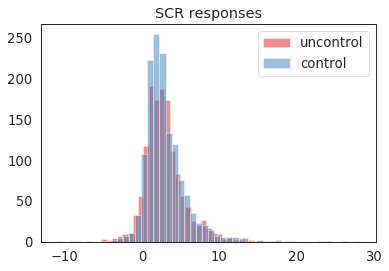

In [8]:
uncon_scr = df[df['Group']=='uncontrol']['SCR'].values
con_scr = df[df['Group']=='control']['SCR'].values

_=plt.hist(uncon_scr,bins=50,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.hist(con_scr,bins=50,alpha=0.5,color=cmap.colors[1],label='control')
_=plt.title('SCR responses')
_=plt.legend()

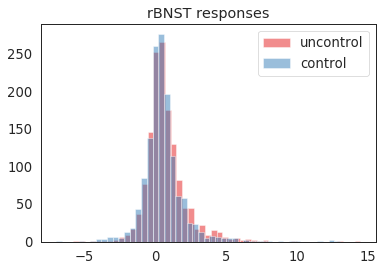

In [9]:
uncon_rBNST = df[df['Group']=='uncontrol']['rBNST'].values
con_rBNST = df[df['Group']=='control']['rBNST'].values

_=plt.hist(uncon_rBNST,bins=50,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.hist(con_rBNST,bins=50,alpha=0.5,color=cmap.colors[1],label='control')
_=plt.title('rBNST responses')
_=plt.legend()

# **Plot: ROI vs. SCR shock response**

In [10]:
def plot_SCR_ROI_corr(roi):
    fig = plt.figure(figsize=(6,5))
    sns.regplot('SCR',roi,df[df['Group']=='control'],color=cmap.colors[1],
                scatter_kws= {'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[1]},label='control',robust=True)
    sns.regplot('SCR',roi,df[df['Group']=='uncontrol'],color=cmap.colors[0],
                scatter_kws={'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[0]},label='uncontrol',robust=True)
    plt.xlabel('Skin Conductance\n[Shock] (A.U.)')
    plt.ylabel('{}\n[Shock] (A.U.)'.format(roi))
    plt.ylim([-4,6])
    plt.legend()
    #plt.title('trial by trial')
    plt.tight_layout()
    #plt.savefig(join(eCON,'scripts/tmp_preproc2/figures/{}_SCR_correlation_tbt.png').format(roi),dpi=600)

[None, None]

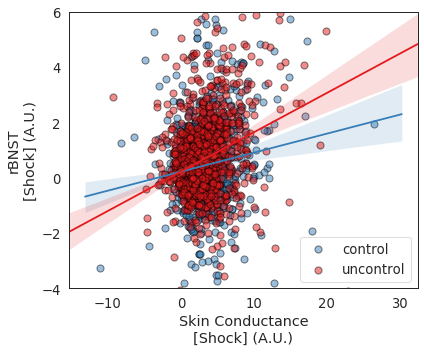

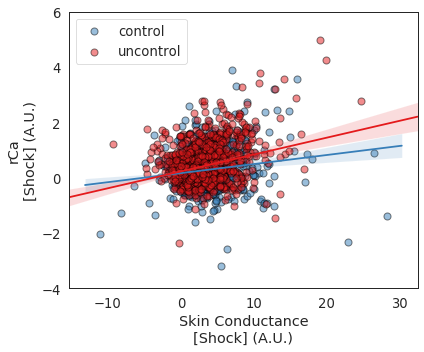

In [11]:
[plot_SCR_ROI_corr(roi) for roi in ['rBNST','rCa']]

In [11]:
df.set_index('Pair',inplace=True)
df.head()

,SCR,rvAI,rdAI,lvAI,ldAI,rPI,lPI,rBNST,lBNST,ACC,...,lPa,rVS,lVS,vmPFC,PCC1,PCC2,rPAG1,lPAG1,SubjID,Group
Pair,,,,,,,,,,,,,,,,,,,,,
P00,8.6095,1.7816,2.1119,-1.0575,2.9644,3.1084,2.7786,6.3267,4.8373,2.6326,...,2.6542,1.6020,1.2372,2.3129,-0.4296,3.8005,-1.0777,2.3216,CON001,control
P00,7.5032,0.8163,3.1294,3.0831,2.2152,1.6196,1.1714,1.7676,5.3251,1.4518,...,2.8288,2.2677,1.9963,-0.3372,-0.0760,-3.4675,2.0552,2.2137,CON001,control
P00,3.7038,0.7600,0.8769,1.8224,0.4235,0.1772,-0.0432,1.0671,0.5296,0.4522,...,0.7408,-0.2517,0.3197,-0.3279,-0.6165,-2.1564,0.6921,0.5358,CON001,control
P00,3.9272,1.3462,1.6302,1.1834,1.1492,0.4893,0.7290,3.6859,3.2630,0.6793,...,1.0341,0.4042,0.6645,-0.0219,-0.2998,-0.3902,0.0272,1.4309,CON001,control
P00,6.9194,1.9489,0.9176,1.0883,0.7360,1.0265,0.9546,0.8350,3.2508,0.4319,...,0.8989,0.9831,1.1389,0.0599,-0.9693,0.3075,-0.8291,0.1176,CON001,control


In [12]:
paired_df = df[['rBNST','SCR']][df['Group']=='uncontrol'] - df[['rBNST','SCR']][df['Group']=='control']
paired_df.rename(columns={'rBNST':'rBNST_diff','SCR':'SCR_diff'},inplace=True)
df.reset_index(inplace=True)
paired_df.head()

,rBNST_diff,SCR_diff
Pair,,
P00,0.0323,-4.8444
P00,-7.5658,-5.3046
P00,3.4530,-2.0391
P00,-3.5240,-4.2247
P00,3.4263,-6.0437


In [166]:
paired_df.to_csv('data/uncon_v_con_rBNST_SCR.txt',sep='\t',float_format='%.4f')

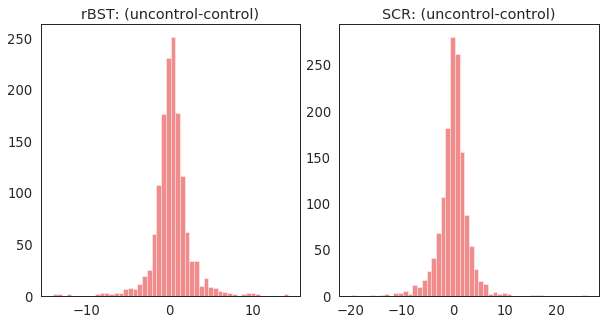

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.15)
_=plt.hist(paired_df['rBNST_diff'],bins=50,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.title('rBST: (uncontrol-control)')
plt.subplot(1,2,2)
_=plt.hist(paired_df['SCR_diff'],bins=50,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.title('SCR: (uncontrol-control)')

In [14]:
from scipy.stats import pearsonr, spearmanr, ttest_rel, ttest_1samp
import math

In [16]:
def ttest_SCR_roi(roi):
    con = []; uncon = []
    for i, row in yoked.iterrows():
        con_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')][roi].values
        uncon_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')][roi].values

        con_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')]['SCR'].values
        uncon_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')]['SCR'].values

        con_rp,_ = spearmanr(con_roi,con_SCR)
        uncon_rp,_ = spearmanr(uncon_roi,uncon_SCR)

        con_zp = math.atanh(con_rp)
        uncon_zp = math.atanh(uncon_rp)

        con.append(con_zp); uncon.append(uncon_zp)
        
    print(roi,': t = %.4f, p = %.4f' %(ttest_1samp(np.subtract(uncon,con),0)))
    

In [17]:
print([ttest_SCR_roi(roi) for roi in rois])

rvAI : t = 0.4261, p = 0.6717
rdAI : t = -0.2575, p = 0.7978
lvAI : t = 0.6546, p = 0.5154
ldAI : t = 0.7079, p = 0.4819
rPI : t = -0.1566, p = 0.8761
lPI : t = -0.3615, p = 0.7191
rBNST : t = 2.7940, p = 0.0071
lBNST : t = 2.1070, p = 0.0396
ACC : t = 0.1285, p = 0.8982
Amygdala_BLBM_La_R : t = -1.3394, p = 0.1858
Amygdala_CeME_R : t = 1.8352, p = 0.0718
Amygdala_BLBM_La_L : t = -0.4619, p = 0.6459
Amygdala_CeME_L : t = 0.4975, p = 0.6208
rCa : t = 2.1823, p = 0.0333
lCa : t = 0.8882, p = 0.3782
rPa : t = 0.7698, p = 0.4447
lPa : t = 1.4811, p = 0.1442
rVS : t = 0.8882, p = 0.3782
lVS : t = 0.7698, p = 0.4447
vmPFC : t = -0.0989, p = 0.9216
PCC1 : t = -0.1593, p = 0.8740
PCC2 : t = -1.2502, p = 0.2164
rPAG1 : t = 0.6361, p = 0.5273
lPAG1 : t = -1.2952, p = 0.2006
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


# **rBST vs. SCR correlation analysis**
1. For each participant get correlation value for ROI and SCR trial-by-trial responses.
2. Z-transform the correlation value (r)
3. Take the paired difference of the transformed correlation value

In [24]:
def get_zcorr_df(roi):
    rba_df = pd.DataFrame()
    for roi in rois:
        for i, row in yoked.iterrows():
            con_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')][roi].values
            uncon_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')][roi].values

            con_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')]['SCR'].values
            uncon_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')]['SCR'].values

            con_rp,_ = spearmanr(con_roi,con_SCR)
            uncon_rp,_ = spearmanr(uncon_roi,uncon_SCR)

            con_zp = math.atanh(con_rp)
            uncon_zp = math.atanh(uncon_rp)

            # Y is the difference (uncon-con) of z-transformed correlation coefficient
            tmp_df = pd.DataFrame(['P{:02}'.format(i), roi,
                                   uncon_zp-con_zp,uncon_zp,con_zp],
                                  index=['Pair','ROI','Y','uncontrol','control']).T
            rba_df = pd.concat([rba_df,tmp_df],axis=0)

    return rba_df

In [25]:
rba_df = get_zcorr_df(rois)
rba_df['Y'] = rba_df['Y'].astype(float)
rba_df['uncontrol'] = rba_df['uncontrol'].astype(float)
rba_df['control'] = rba_df['control'].astype(float)

Use the following pivot commad if you want a column for each roi
> rba_df.pivot(index='Pair',columns='ROI')

Later if you want to add covarites, setting 'Pair' column as the index would help in joining the STAI scores to the rba dataframe
> rba_df.set_index('Pair',inplace=True)

In [26]:
rba_df[rba_df['ROI']=='rBNST'].to_csv('data/rBNST_SCR_zcorr.txt',sep='\t',float_format='%.4f')

In [27]:
df_for_paired_violin = rba_df[rba_df['ROI']=='rBNST']
df_for_paired_violin = pd.melt(df_for_paired_violin,id_vars='Pair',value_vars=['uncontrol','control'],var_name='Group',value_name='zcorr')
df_for_paired_violin.set_index('Pair',inplace=True)

In [105]:
df_for_paired_violin.replace({'Group':{'uncontrol':'Uncontrollable','control':'Controllable'}},inplace=True)

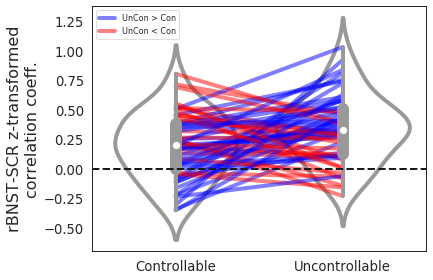

In [110]:
plt.figure(figsize=(6,4))
is_pos = []
for pair in df_for_paired_violin.index.unique():
    current_pair_df = df_for_paired_violin.loc[pair]
    if np.diff(current_pair_df['zcorr'][::-1])[0] > 0:
        color,label = 'blue','neg'
        is_pos.append(True)
    elif np.diff(current_pair_df['zcorr'][::-1])[0] < 0:
        color,label = 'red','pos'
        is_pos.append(False)
    else:
        color = 'purple'
    a = sns.lineplot(x='Group',y='zcorr',data=current_pair_df,label=label,legend=False,color=color,linewidth=4,alpha=0.5)
    
    
handels = np.array(a.get_legend_handles_labels()[0])
labels =np.array(a.get_legend_handles_labels()[1])
pos_handel = handels[labels=='pos'][0]
neg_handel = handels[labels=='neg'][0]

sns.violinplot(x='Group',y='zcorr',data=df_for_paired_violin,
               color='white',saturation=0.25,
               order=['Controllable','Uncontrollable'],linewidth=4)
plt.axhline(y=0,linewidth=2,linestyle='--',color='k')
#plt.xlabel('Group',fontdict={'size':16,'weight':500})
plt.xlabel('')
plt.legend([neg_handel,pos_handel],['UnCon > Con','UnCon < Con'],loc='upper left',fontsize=8)
plt.ylabel('rBNST-SCR z-transformed\ncorrelation coeff.',fontdict={'size':16,'weight':500})
plt.tight_layout()
plt.savefig('rBNST-SCR_corr.png',dpi=300)

## **Distribution of the z-transformed SCR-rBNST correlation values z(r)**
### **Paired Sample Test**

$$H_{0}: \mu_{z(r)_{runcontrol-control}}=0$$

In [30]:
def rel_samp_perm_test(samp,n_perms):
    n, k, samp_dist = len(samp), 0, []
    alt_obs = abs(np.mean(samp))
    for j in range(n_perms):
        null_obs = np.mean([val*np.random.choice([-1,1]) for val in samp])
        samp_dist.append(null_obs)
        k += abs(null_obs) > alt_obs
        
    return(samp_dist,(k+1)/(n_perms+1))

In [31]:
print('Paired Samples T-test p-value: %.3f' %(ttest_1samp(rba_df[rba_df['ROI']=='rBNST'].Y.values,0)[1]))
samp_dist, p_val = rel_samp_perm_test(rba_df[rba_df['ROI']=='rBNST'].Y.values,50000)
print('Paired Samples permutation test p-value: %.3f' %(p_val))

Paired Samples T-test p-value: 0.007
Paired Samples permutation test p-value: 0.007


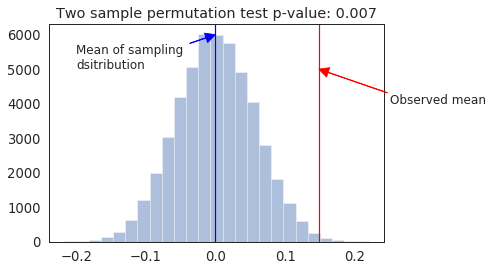

In [47]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(rba_df[rba_df['ROI']=='rBNST'].Y.values),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')
plt.annotate('Observed mean',
             xy=(np.mean(rba_df[rba_df['ROI']=='rBNST'].Y.values),5000),
             xytext=(0.25,4000), arrowprops={'color':'red','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.annotate('Mean of sampling \ndsitribution',
             xy=(np.mean(samp_dist),6000),
             xytext=(-0.2,5000), arrowprops={'color':'blue','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.title('Two sample permutation test p-value: %.3f' %(p_val))

### **To run an intercept model on rBNST save a dataset with just rBNST**

In [33]:
rba_df[rba_df['ROI']=='rBNST'].to_csv('data/uncon_v_con_rBNST_SCR_zcorr.txt',sep='\t',float_format='%.4f',index=False)

## Get the STAI scores to be used as covariates

In [34]:
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))
print(scores.head())
print(scores.tail())

    SubID    Group  TRAIT  STATE
0  CON001  control     27     24
1  CON002  control     27     26
2  CON003  control     36     26
3  CON004  control     21     21
4  CON005  control     33     26
      SubID      Group  TRAIT  STATE
121  CON119  uncontrol     38     30
122  CON120  uncontrol     35     35
123  CON121  uncontrol     53     55
124  CON123  uncontrol     30     23
125  CON125  uncontrol     38     30


In [35]:
new_score_df = pd.DataFrame()
for i,row in yoked.iterrows():
    conTrait = scores[scores['SubID'] == row['control']]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == row['uncontrol']]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == row['control']]['STATE'].values[0]
    unconState = scores[scores['SubID'] == row['uncontrol']]['STATE'].values[0]
    
    tmp_df = pd.DataFrame(['P{:02d}'.format(i),row['uncontrol'],row['control'],
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)


new_score_df.columns = pd.MultiIndex.from_tuples(new_score_df.columns)

In [36]:
print(new_score_df.head())
print(new_score_df.tail())

         SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                                                                         
P00     CON031  CON001        27      27         0    27        22      24   
P01     CON021  CON002        36      27         9  31.5        30      26   
P02     CON022  CON003        37      36         1  36.5        29      26   
P03     CON030  CON004        24      21         3  22.5        20      21   
P04     CON023  CON005        33      33         0    33        32      26   

                      
     uncon-con  mean  
Pair                  
P00         -2    23  
P01          4    28  
P02          3  27.5  
P03         -1  20.5  
P04          6    29  
         SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                               

## Normalize the STAI score

In [37]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scores_norm = pd.DataFrame(ss.fit_transform(new_score_df[[('STATE', 'mean'),('STATE','uncon-con'),('TRAIT', 'mean'),('TRAIT','uncon-con')]]),
                          columns=['STATEmean','STATEdiff','TRAITmean','TRAITdiff'],index=new_score_df.index)


In [38]:
scores_norm.head()

,STATEmean,STATEdiff,TRAITmean,TRAITdiff
Pair,,,,
P00,-1.213278,-0.144191,-0.988402,-0.055850
P01,-0.419284,0.496243,-0.407588,3.127601
P02,-0.498684,0.389504,0.237760,0.297867
P03,-1.610275,-0.037452,-1.569215,1.005300
P04,-0.260486,0.709720,-0.213984,-0.055850


# Plot of averaged response
All trials averaged with each perticipant

In [39]:
ROI_SCR_avreaged_resp_df = df.groupby(['Pair','Group','SubjID']).mean().reset_index()

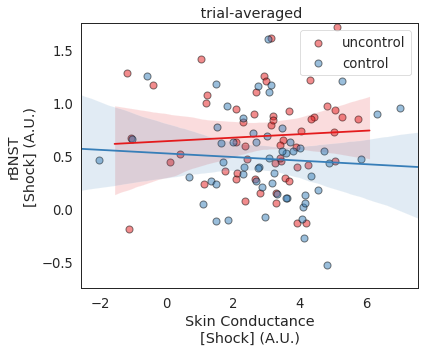

In [40]:
cmap = plt.get_cmap('Set1')
fig = plt.figure(figsize=(6,5))
sns.regplot('SCR','rBNST',
            ROI_SCR_avreaged_resp_df[ROI_SCR_avreaged_resp_df['Group']=='uncontrol'],color=cmap.colors[0],
            scatter_kws={'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[0]},label='uncontrol',robust=True)
sns.regplot('SCR','rBNST',
            ROI_SCR_avreaged_resp_df[ROI_SCR_avreaged_resp_df['Group']=='control'],color=cmap.colors[1],
            scatter_kws={'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[1]},label='control',robust=True)

plt.xlabel('Skin Conductance\n[Shock] (A.U.)')
plt.ylabel('rBNST\n[Shock] (A.U.)')
plt.ylim(-0.75,1.75)
plt.title(' trial-averaged')
plt.legend()
plt.tight_layout()
plt.savefig(join(eCON,'scripts/tmp_preproc2/figures/{}_SCR_correlation_taveg.png').format('rBNST'),dpi=600)

In [42]:
paired_df.head()

,rBNST_diff,SCR_diff
Pair,,
P00,0.0323,-4.8444
P00,-7.5658,-5.3046
P00,3.4530,-2.0391
P00,-3.5240,-4.2247
P00,3.4263,-6.0437
